#Import and install modules

In [1]:
!pip install hazm

In [2]:
import re, hazm, os, json, nltk
import pickle
import numpy as np
import pandas as pd
from nltk import word_tokenize 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
nltk.download('wordnet')
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 AI-4.gdoc
 apply.gsheet
 classifier
'Colab Notebooks'
 CV.pdf
 data
'Email for Graduate Application.gdoc'
'My Prof.s.gsheet'
 nlp-project.ipynb
 points.json
 Prof.s.gsheet
'project Bsc'
'Recommendation Letter_Rezvan Karaji_Nevada.rtf'
 sop.gdoc
 SpamDetection.ipynb
 tfidf_en.sav
 tfidf_fa.sav
 transcript-official.pdf
 tweet.csv


In [5]:
filename = 'tweet.csv'
data = pd.read_csv(filename, encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,5,6,11,12,13,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Analyze data

In [6]:
data.head()

,Unnamed: 0,id,username,title,about,members,posts_count,language,avg_view,last_dump_date,last_cold_date,duration_update,following_count,verified,favourites_count,location,url,join_date,deleted,index_name,UTC_date,date,views,retweet_count,text,fwdfrom,media,hashtags,to,from,post_id,link,dump_type,meta,is_adv,bi-keywords,keywords,neg_adj,pos_adj,sentiment,mentions,locations,urls,cashtags
0,0,9.772081e+17,jasooyichii,milad mohammadi,Exhibitions reporter/\nmr event/\norganizer of...,856,470,NaN,0.0,2020-10-26,2020-10-09,24,774,0,1927.0,tehran - iran,https://t.co/uz1hdKY1V8,2018-03-23T15:38:55,0.0,tw-sourceinfo-2020-10,2020-10-25T20:40:58,2020-10-25 17:10:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.314951e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:29:51,2020-10-10 15:29:51,7897.0,457.0,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,"{'username': 'febrahimzade', 'id': '198563041'...",{'caption': 'آن شب اسفندماه که برای نخستین بار...,"['محمدرضاشجریان', 'افسانه_شجریان']","{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1886.0,https://twitter.com/i/web/status/1314951285540...,scheduled,['اجتماعی'],1.0,"['اسفندماه خبر', 'خبر درگذشت', 'درگذشت محمدرضا...","['پدر', 'درگذشت', 'علاقه', 'بیمارستان', 'پاسخ'...","['بار', 'درگذشت']","['آرامش', 'باور', 'زنده']",positive,NaN,NaN,NaN,NaN
2,2,1.314951e+18,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:28:26,2020-10-10 15:28:26,1.0,0.0,@daydreaminblack Niiiice😂😂😂😂😂,NaN,NaN,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1885.0,https://twitter.com/i/web/status/1314950928517...,scheduled,['متفرقه'],0.0,[],"['daydreaminblack', 'Niiiice']",NaN,NaN,neutral,['daydreaminblack'],NaN,NaN,NaN
3,3,1.314951e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:28:00,2020-10-10 15:28:00,33.0,1.0,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,"{'username': 'helia_hh', 'id': '3025201221', '...",NaN,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1884.0,https://twitter.com/i/web/status/1314950817338...,scheduled,['هنری'],0.0,"['رفتن شجریان', 'شجریان چهر', 'چهر غمبار', 'غم...","['رفتن', 'شجریان', 'مچاله', 'علیزاده', 'چهر', ...","['جدا', 'مچاله']",NaN,negative,NaN,NaN,NaN,NaN
4,4,1.314895e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T11:47:36,2020-10-10 11:47:36,3046.0,191.0,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,"{'username': 'Javadhastam2', 'id': '1111065915...",{'caption': 'دیگه تویی که تا دیروز عکس سردار د...,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1883.0,https://twitter.com/i/web/status/1314895352772...,scheduled,['هنری'],1.0,"['تویی عکس', 'عکس سردار', 'سردار دلها', 'دلها ...","['عکس', 'استوری', 'تویی', 'شجریان', 'سردار', '...",['پست'],NaN,negative,NaN,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196368 entries, 0 to 1196367
Data columns (total 44 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1196368 non-null  object 
 1   id                1196355 non-null  float64
 2   username          257913 non-null   object 
 3   title             257719 non-null   object 
 4   about             176930 non-null   object 
 5   members           242382 non-null   object 
 6   posts_count       242381 non-null   object 
 7   language          938461 non-null   object 
 8   avg_view          242381 non-null   float64
 9   last_dump_date    242381 non-null   object 
 10  last_cold_date    242381 non-null   object 
 11  duration_update   242373 non-null   object 
 12  following_count   242369 non-null   object 
 13  verified          242381 non-null   object 
 14  favourites_count  242381 non-null   float64
 15  location          134416 non-null   object 
 16  

In [8]:
# sentiment
data = data[['language','text', 'sentiment']]

data.columns = ['lang', 'text', 'target']
data = data[1:]

In [9]:
data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,positive
2,en,@daydreaminblack Niiiice😂😂😂😂😂,neutral
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,negative
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,negative
5,fa,لازم نیست راجع‌به هر مسئله‌ای نظر بدی و موضع‌گ...,dipole


drop useless data

In [10]:
data = data[~data['target'].isnull()]
data = data[data['target'].notna()]
data = data[~data['text'].isnull()]
data = data[data['text'].notna()]
# not using dipole tag
data = data[~(data['target']=='dipole')]

In [11]:
tages = list(set(data['target'].values))
tages

['negative', 'positive', 'neutral']

No handles with labels found to put in legend.


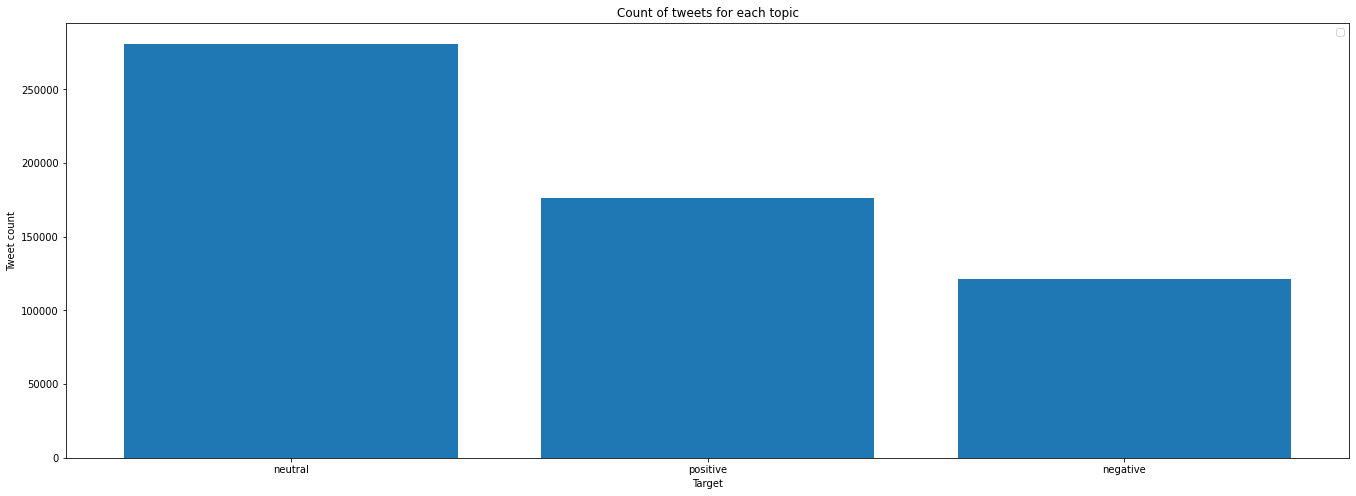

In [12]:
class_count = data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

## Farsi

In [13]:
is_fa =  data['lang'] == 'fa'
fa_data = data[is_fa]
fa_data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,positive
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,negative
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,negative
6,fa,به نظر من اینکه رفیق صمیمیت لانگ دیستنس باشه ب...,positive
13,fa,اون که سپردی به باد حسرت تمام دار و ندار ما بو...,positive


In [14]:
fa_data.shape

(305952, 3)

No handles with labels found to put in legend.


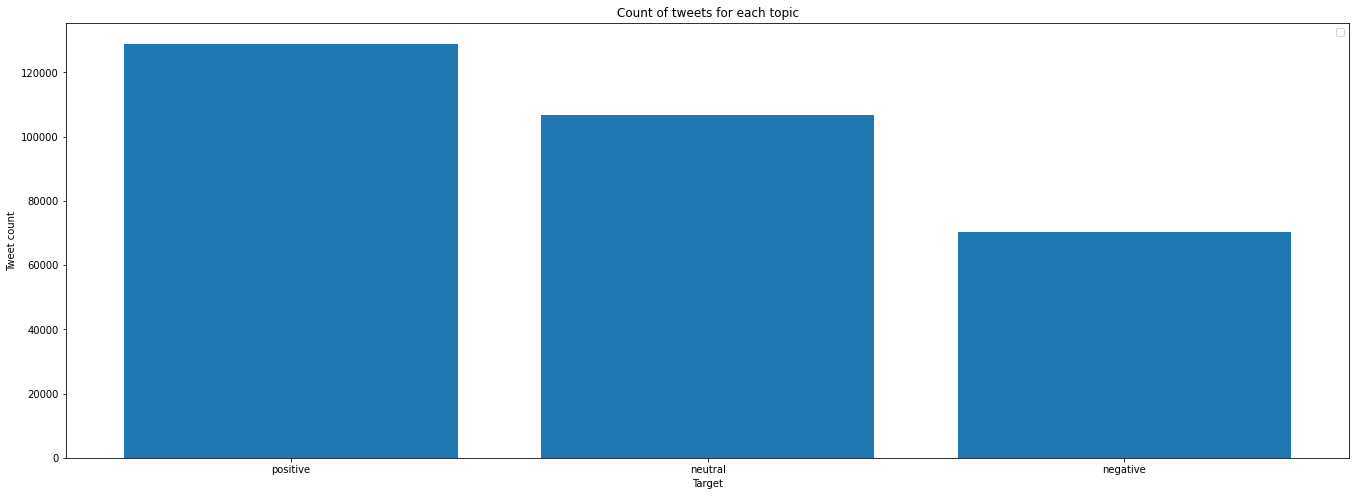

In [15]:
class_count = fa_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

we need to normalize volum of data in each category!

## English

In [16]:
is_en =  data['lang'] == 'en'
en_data= data[is_en]
en_data.head()

,lang,text,target
2,en,@daydreaminblack Niiiice😂😂😂😂😂,neutral
23,en,@safewordthe۲nd ….,neutral
39,en,"@wahid_taniwal It seems, Taliban endorsed Pres...",positive
40,en,"Mujahid told CBS News in a phone interview, «W...",positive
46,en,Watch out😱🙈🙉 https: //t. co/eyCX۳SFGnG,neutral


In [17]:
en_data.shape

(273316, 3)

No handles with labels found to put in legend.


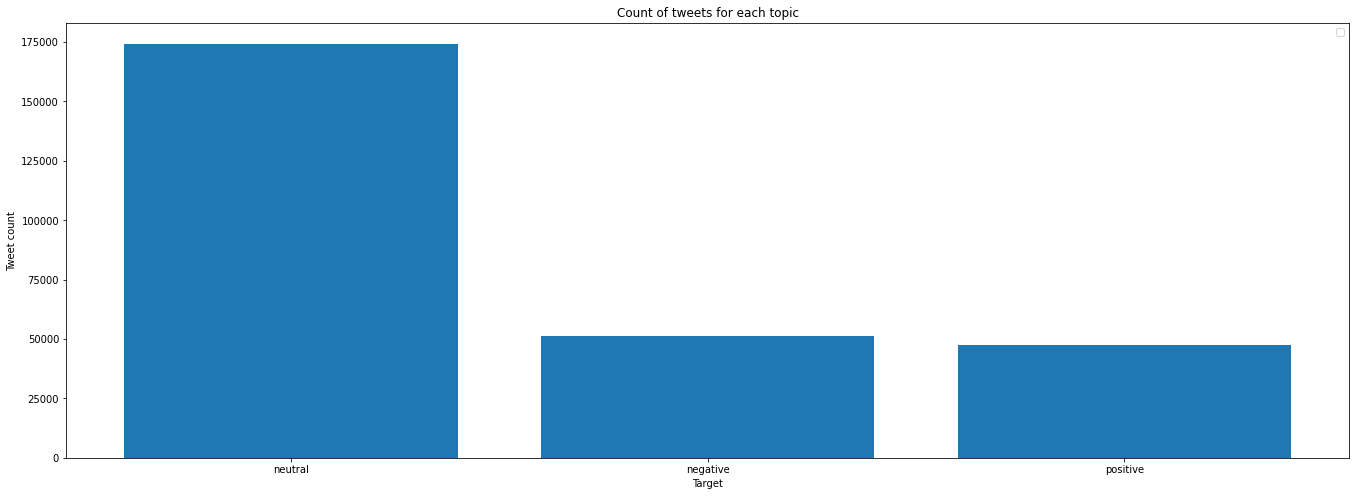

In [18]:
class_count = en_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

we need to normalize volum of data in each category!

#Preprocess

In [19]:
def tokenizer(text):
  text = text.str.split(' ')
  return text

In [20]:
def stemLemmaStopWord(stemmer, lemmatizer, stopwords, alphabet, tokens):
  final_tokens = []
  for token in tokens:
    stemmed_token = stemmer.stem(lemmatizer.lemmatize(token))
    if '#' in stemmed_token:
      stemmed_token = stemmed_token.split('#')[0]
    if token not in stopwords and stemmed_token not in stopwords and not token == '' and stemmed_token not in alphabet:
      final_tokens.append(stemmed_token)
  return final_tokens

In [21]:
def num_words(words):
  return len(words)

def num_distinct_words(words):
  return len(set(words))

def all_words(data):
  words = set()
  for text in data.text:
    for word in text:
      words.add(word)
  return words

##Farsi

In [22]:
fa_data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,positive
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,negative
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,negative
6,fa,به نظر من اینکه رفیق صمیمیت لانگ دیستنس باشه ب...,positive
13,fa,اون که سپردی به باد حسرت تمام دار و ندار ما بو...,positive


In [23]:
def fa_normalize(text):
  text = text.replace(to_replace =r"[ئيی]", value = 'ی', regex = True)
  text = text.replace(to_replace =r"[ك]", value = 'ک', regex = True)
  text = text.replace(to_replace =r"[ؤ]", value = 'و', regex = True)
  text = text.replace(to_replace =r"[ة]", value = 'ه', regex = True)
  text = text.replace(to_replace=r"[إأآا]", value="ا", regex=True)
  text = text.replace(
            to_replace=r"[^ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی]", value=" ", regex=True
        )
  text = text.replace(to_replace=r'(.)\1+', value=r'\1', regex=True)
  text = text.replace(to_replace =r"[^\S\n\t]+", value = ' ', regex = True)
  return text  


fa_data.text = fa_normalize(fa_data.text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


tokenize

In [24]:
fa_data.text = tokenizer(fa_data.text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Stem Lemma StopWord

In [25]:
fa_stemmer = hazm.Stemmer()
fa_lemmatizer = hazm.Lemmatizer()
fa_stopwords = hazm.stopwords_list()
fa_alphabet = set(list('ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی'))

fa_data.text = fa_data.apply(lambda row: stemLemmaStopWord(fa_stemmer, fa_lemmatizer, fa_stopwords, fa_alphabet, row.text), axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


number of words

In [26]:
fa_data['words_num'] = fa_data.apply(lambda row: num_words(row.text), axis=1)
fa_data['distinct_words_num'] = fa_data.apply(lambda row: num_distinct_words(row.text), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Remove less than 4 words long data

In [27]:
fa_data = fa_data[fa_data.words_num > 3]
fa_data .reset_index(drop=True, inplace=True)
fa_data.head()

,lang,text,target,words_num,distinct_words_num
0,fa,"[, شب, اسفندماه, خبر, درگذ, محمدرضاشجر, امد, م...",positive,28,24
1,fa,"[جدا, رفتن, شجر, چهر, , غمبار, همایون, علیزاده...",negative,11,11
2,fa,"[دیگه, دیروز, عکس, سردار, دل, استور, میکرد, نم...",negative,12,12
3,fa,"[رفیق, صمیم, لانگ, دیستنس, باشه, مراتب, سخ, , ...",positive,12,10
4,fa,"[اون, سپرد, باد, حسر, ندار, زویازاکار]",positive,6,6


In [28]:
words = all_words(fa_data)
print('all farsi words: ', sum(fa_data.words_num), ' and distinct farsi words: ', len(words))

all farsi words:  3052379  and distinct farsi words:  84081


##English

In [29]:
en_data.head()

,lang,text,target
2,en,@daydreaminblack Niiiice😂😂😂😂😂,neutral
23,en,@safewordthe۲nd ….,neutral
39,en,"@wahid_taniwal It seems, Taliban endorsed Pres...",positive
40,en,"Mujahid told CBS News in a phone interview, «W...",positive
46,en,Watch out😱🙈🙉 https: //t. co/eyCX۳SFGnG,neutral


In [30]:
def en_normalize(text):
  text = text.replace(to_replace =r'@([A-Za-z0-9_]+)', value = '', regex = True)
  text = text.replace(to_replace=r"http([^\s\\]+)", value="", regex=True)
  text = text.str.lower()
  text = text.replace(to_replace =r"[^a-z]", value = ' ', regex = True)
  text = text.replace(to_replace=r'(.)\1+', value=r'\1', regex=True)
  text = text.replace(to_replace =r"[^\S\n\t]+", value = ' ', regex = True)
  return text  

en_data.text = en_normalize(en_data.text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


tokenize

In [31]:
en_data.text = tokenizer(en_data.text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Stem Lemma StopWord

In [32]:
en_stemmer = PorterStemmer()
en_lemmatizer = WordNetLemmatizer()
en_stopwords = set(stopwords.words("english"))
en_alphabet = set(list('abcdefghijklmnopqrstuvwxyz'))

en_data.text = en_data.apply(lambda row: stemLemmaStopWord(en_stemmer, en_lemmatizer, en_stopwords, en_alphabet, row.text), axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


number of words

In [33]:
en_data['words_num'] = en_data.apply(lambda row: num_words(row.text), axis=1)
en_data['distinct_words_num'] = en_data.apply(lambda row: num_distinct_words(row.text), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Remove less than 4 words long data

In [34]:
en_data = en_data[en_data.words_num > 3]
en_data .reset_index(drop=True, inplace=True)
en_data.head()

,lang,text,target,words_num,distinct_words_num
0,en,"[sem, taliban, endors, presid, trump, nomin, p...",positive,8,8
1,en,"[mujahid, told, cb, news, phone, interview, ho...",positive,31,31
2,en,"[watch, co, eycx, sfgng]",neutral,4,4
3,en,"[mentalhealth, mentalhealthfor, co, sqk]",neutral,4,4
4,en,"[pictur, speak, milion, word, ye, peopl, absor...",positive,25,23


In [35]:
words = all_words(en_data)
print('all english words: ', sum(en_data.words_num), ' and distinct english words: ', len(words))

all english words:  2321967  and distinct english words:  173613


## Normalize class sizes

In [36]:
def normalize_size(data):
  class_count = data['target'].value_counts()
  min_size = class_count.min() - 1

  new_data = pd.DataFrame([], columns=data.columns)

  for x in tages:
    data_x = data[data.target == x]
    data_x.reset_index(drop=True, inplace=True)
    data_x = data_x[:min_size]
    frames = [new_data, data_x]
    new_data = pd.concat(frames)

  new_data.reset_index(drop=True, inplace=True)
  return new_data

In [37]:
fa_data = normalize_size(fa_data)
# shuffle
fa_data  = fa_data.sample(frac = 1)
fa_data.reset_index(drop=True, inplace=True)

No handles with labels found to put in legend.


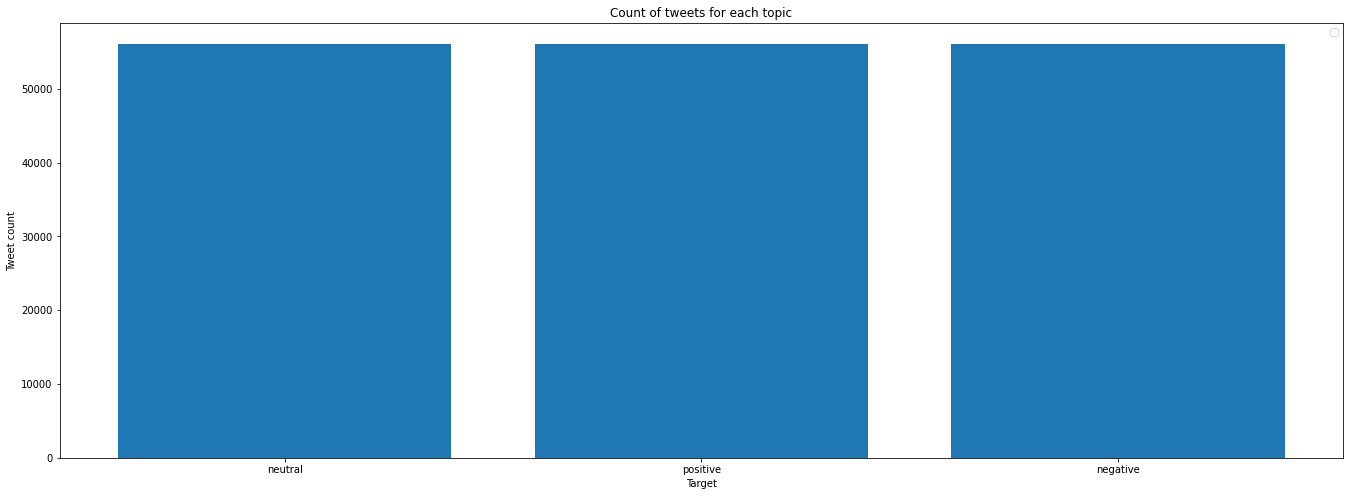

In [38]:
class_count = fa_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

In [39]:
en_data = normalize_size(en_data)
# shuffle
en_data  = en_data.sample(frac = 1)
en_data.reset_index(drop=True, inplace=True)

No handles with labels found to put in legend.


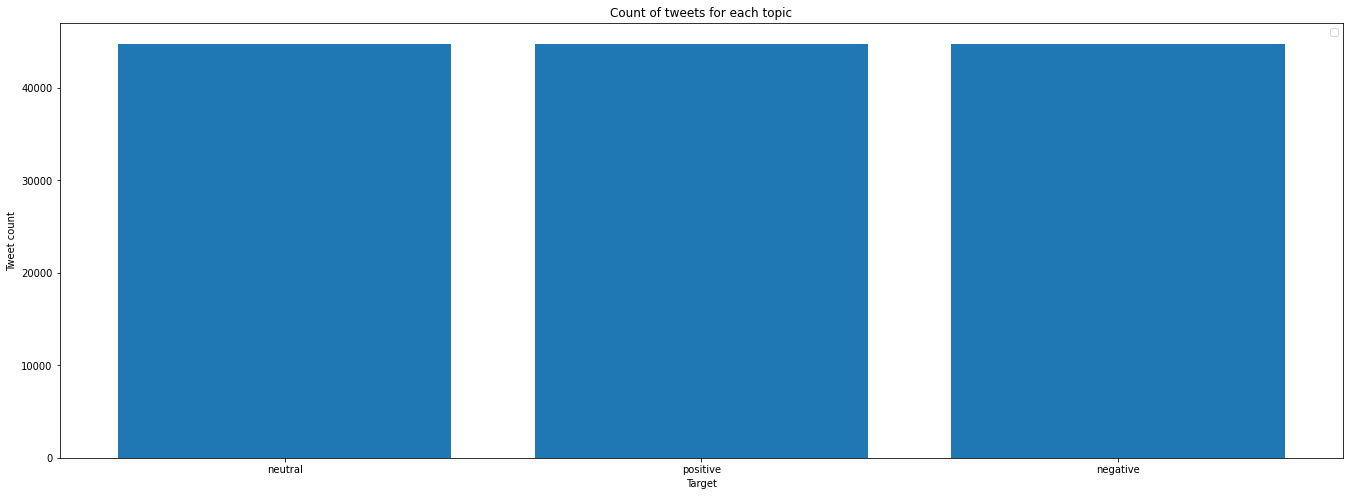

In [40]:
class_count = en_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

#Prepare test and train sets

devide farsi test and train


In [41]:
total_len = fa_data.shape[0]

train_len = 60*total_len//100
train_fa_data = fa_data.iloc[:train_len, :]
test_fa_data = fa_data.iloc[train_len:, :]

In [42]:
# dev data
total_len = test_fa_data.shape[0]
dev_len = 50*total_len//100
dev_fa_data = test_fa_data.iloc[:dev_len, :]
test_fa_data = test_fa_data.iloc[dev_len:, :]

devide english test and train

In [43]:
total_len = en_data.shape[0]

train_len = 60*total_len//100
train_en_data = en_data.iloc[:train_len, :]
test_en_data = en_data.iloc[train_len:, :]

In [44]:
# dev data
total_len = test_en_data.shape[0]
dev_len = 50*total_len//100
dev_en_data = test_en_data.iloc[:dev_len, :]
test_en_data = test_en_data.iloc[dev_len:, :]

#TF-IDF Vectorizer

devide farsi X and y

In [45]:
X_fa_train = train_fa_data.text.apply(lambda x: np.str_(x))
y_fa_train = train_fa_data.target

X_fa_test = test_fa_data.text.apply(lambda x: np.str_(x))
y_fa_test = test_fa_data.target

X_fa_dev = dev_fa_data.text.apply(lambda x: np.str_(x))
y_fa_dev = dev_fa_data.target

devide english X and y

In [46]:
X_en_train = train_en_data.text.apply(lambda x: np.str_(x))
y_en_train = train_en_data.target

X_en_test = test_en_data.text.apply(lambda x: np.str_(x))
y_en_test = test_en_data.target

X_en_dev = dev_en_data.text.apply(lambda x: np.str_(x))
y_en_dev = dev_en_data.target

Farsi

In [47]:
tfidfVectorizer = TfidfVectorizer(min_df = 5, max_features = 1000)
tfidfVectorizer.fit(X_fa_train)
X_train_fa_vector = tfidfVectorizer.transform(X_fa_train)
X_test_fa_vector = tfidfVectorizer.transform(X_fa_test)
X_dev_fa_vector = tfidfVectorizer.transform(X_fa_dev)

# save
filename = 'tfidf_fa.sav'
pickle.dump(tfidfVectorizer, open(filename, 'wb'))

English

In [48]:
tfidfVectorizer.fit(X_en_train)
X_train_en_vector = tfidfVectorizer.transform(X_en_train)
X_test_en_vector = tfidfVectorizer.transform(X_en_test)
X_dev_en_vector = tfidfVectorizer.transform(X_en_dev)

# save
filename = 'tfidf_en.sav'
pickle.dump(tfidfVectorizer, open(filename, 'wb'))

#NB

Farsi

In [49]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_fa_vector, y_fa_train)
prediction_fa = nb_model.predict(X_test_fa_vector)
print(classification_report(y_fa_test, prediction_fa))

              precision    recall  f1-score   support

    negative       0.69      0.63      0.66     11160
     neutral       0.59      0.68      0.63     11333
    positive       0.63      0.59      0.61     11171

    accuracy                           0.63     33664
   macro avg       0.64      0.63      0.63     33664
weighted avg       0.64      0.63      0.63     33664



In [50]:
filename = 'nb_fa.sav'
pickle.dump(nb_model, open(filename, 'wb'))

english

In [51]:
nb_model.fit(X_train_en_vector, y_en_train)
prediction_en = nb_model.predict(X_test_en_vector)
print(classification_report(y_en_test, prediction_en))

              precision    recall  f1-score   support

    negative       0.72      0.74      0.73      8950
     neutral       0.72      0.65      0.68      9034
    positive       0.72      0.77      0.74      8901

    accuracy                           0.72     26885
   macro avg       0.72      0.72      0.72     26885
weighted avg       0.72      0.72      0.72     26885



In [52]:
filename = 'nb_en.sav'
pickle.dump(nb_model, open(filename, 'wb'))

#RF

##tune

In [ ]:
parameters = {#'n_estimators': (10, 30, 50, 70, 90),
              #'criterion': ('gini', 'entropy'),
              'max_depth': (200, 250, 300),
              #'max_features': ('auto', 'sqrt'),
              #'min_samples_split': (2, 3),
              'min_samples_leaf': (15, 20),
              # 'bootstrap' : (True, False),
              #'min_weight_fraction_leaf': (0.0, 0.1, 0.2, 0.3, 0.4)    
}

In [ ]:
# rf_grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score = False), param_grid = parameters, cv = 3, verbose = True)

farsi

In [ ]:
# rf_grid_model = rf_grid.fit(X_dev_fa_vector, y_fa_dev)
# rf_grid_model.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.0min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

english

In [ ]:
# rf_grid_model = rf_grid.fit(X_dev_en_vector, y_en_dev)
# rf_grid_model.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   49.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

##train and evaluate

farsi

In [59]:
randomForestClassifier = RandomForestClassifier(min_samples_leaf=5, n_jobs=-1)
randomForestClassifier.fit(X_train_fa_vector, y_fa_train)
prediction_fa = randomForestClassifier.predict(X_test_fa_vector)
print(classification_report(y_fa_test, prediction_fa))

filename = 'rf_fa.sav'
pickle.dump(randomForestClassifier, open(filename, 'wb'))

              precision    recall  f1-score   support

    negative       0.79      0.69      0.73     11160
     neutral       0.69      0.82      0.75     11333
    positive       0.74      0.69      0.72     11171

    accuracy                           0.73     33664
   macro avg       0.74      0.73      0.73     33664
weighted avg       0.74      0.73      0.73     33664



english

In [60]:
randomForestClassifier = RandomForestClassifier(min_samples_leaf=5, n_jobs=-1)
randomForestClassifier.fit(X_train_en_vector, y_en_train)
prediction_en = randomForestClassifier.predict(X_test_en_vector)
print(classification_report(y_en_test, prediction_en))

filename = 'rf_en.sav'
pickle.dump(randomForestClassifier, open(filename, 'wb'))

              precision    recall  f1-score   support

    negative       0.81      0.76      0.78      8950
     neutral       0.75      0.81      0.78      9034
    positive       0.84      0.81      0.82      8901

    accuracy                           0.79     26885
   macro avg       0.80      0.79      0.79     26885
weighted avg       0.80      0.79      0.79     26885

